<a href="https://colab.research.google.com/github/stewieboomhauer/roBERT/blob/main/%22Transformers_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------------------------------------------
# **1. Installing Simple Transformers**
-------------------------------------------------------

In [1]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 23.2MB/s 
     |████████████████████████████████| 7.0MB 38.7MB/s 
     |████████████████████████████████| 2.0MB 55.4MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 317kB 52.3MB/s 
     |████████████████████████████████| 1.2MB 47.1MB/s 
     |████████████████████████████████| 3.2MB 35.3MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 194kB 54.3MB/s 
     |████████████████████████████████| 2.0MB 46.2MB/s 
     |████████████████████████████████| 112kB 58.3MB/s 
     |████████████████████████████████| 4.6MB 46.2MB/s 
     |████████████████████████████████| 163kB 51.4MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
     |████████████████████████████████| 112kB 56.9MB/s 
     |████████████████████████████████| 245kB 56.7MB/s 
     |████████████████████████████████| 102kB 14.2MB

-------------------------------------------------------
# **2. Loading created in Label Studio Data**
-------------------------------------------------------


In [84]:
import simpletransformers
from simpletransformers.ner import NERModel,NERArgs
import json
import pandas as pd
import torch
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import random
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(color_codes=True)
# sn.set(font_scale=1)
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [85]:

with open('/content/drive/MyDrive/files/spacy_train.json', encoding='utf8') as json_file:
    train_data = json.load(json_file)


In [86]:
with open('/content/drive/MyDrive/files/spacy_dev.json', encoding='utf8') as json_file:
    dev_data = json.load(json_file)

In [87]:

with open('/content/drive/MyDrive/files/spacy_test.json', encoding='utf8') as json_file:
    evl_data = json.load(json_file)


-------------------------------------------------------
# **3. Preprocessing**
**3.1 Creating train-, dev- and test-datasets**
-------------------------------------------------------
-------------------------------------------------------

In [88]:
sentence_train = {}
sentence_dev = {}
train_ner = []
dev_ner = []
count_train = 0
count_test = 0

for elem in train_data:
    for dicts in elem["paragraphs"]:
        for dictOfTokens in dicts["sentences"]:
            count_train = count_train + 1
            sentence_train["Sentence: " + str(count_train)] = []
            for annotation in dictOfTokens["tokens"]:
                for key, value in annotation.items():
                    if key == "orth":
                        sentence_train["Sentence: " + str(count_train)].append(value)
                    elif key == "ner":
                        train_ner.append(value)


df_train = pd.concat({k: pd.Series(v) for k, v in sentence_train.items()}).reset_index()
df_train.columns = ['sentence_id', 'del','words']
df_train['labels'] = train_ner
df_train.drop(columns=['del'], inplace=True, axis=1)


In [89]:
for elem in dev_data:
    for dicts in elem["paragraphs"]:
        for dictOfTokens in dicts["sentences"]:
            count_test = count_test + 1
            sentence_dev["Sentence: " + str(count_test)] = []
            for annotation in dictOfTokens["tokens"]:
                for key, value in annotation.items():
                    if key == "orth":
                        sentence_dev["Sentence: " + str(count_test)].append(value)
                    elif key == "ner":
                        dev_ner.append(value)


df_dev = pd.concat({k: pd.Series(v) for k, v in sentence_dev.items()}).reset_index()
df_dev.columns = ['sentence_id', 'del','words']
df_dev['labels'] = dev_ner
df_dev.drop(columns=['del'], inplace=True, axis=1)



In [90]:
count_evl = 0
sentence_test = {}
test_ner = []
list_true = []
tokens = []



for elem in evl_data:
    for dicts in elem["paragraphs"]:
        for dictOfTokens in dicts["sentences"]:
            count_evl = count_evl + 1
            sentence_test["Sentence: " + str(count_evl)] = []
            list_true.append([])
            for annotation in dictOfTokens["tokens"]:
                for key, value in annotation.items():
                    if key == "orth":
                        sentence_test["Sentence: " + str(count_evl)].append(value)
                        tokens.append(value)
                    elif key == "ner":
                        test_ner.append(value)

dict_true = dict(zip(tokens, test_ner))

del dict_true['\n\n']
del dict_true[' \n\n']
del dict_true['\n']
new_dict_true = []

for k, v in dict_true.items():
  new_dict_true.append({k:v})


df_test = pd.concat({k: pd.Series(v) for k, v in sentence_test.items()}).reset_index()

df_test.columns = ['sentence_id', 'del','words']
df_test['labels'] = test_ner
df_test.drop(columns=['del'], inplace=True, axis=1)


texts = []
for elem in evl_data:
    for dicts in elem["paragraphs"]:
        for keys, text in dicts.items():
            if keys == "raw":
                texts.append(text)

text = []
for elem in texts:
  text.append(elem)


In [91]:
df_dev

,sentence_id,words,labels
0,Sentence: 1,Use,O
1,Sentence: 1,Letterboxd,B-STUDIO
2,Sentence: 1,to,O
3,Sentence: 1,create,O
4,Sentence: 1,a,O
...,...,...,...
6041,Sentence: 380,real,O
6042,Sentence: 380,sources,O
6043,Sentence: 380,from,O
6044,Sentence: 380,Disney,B-STUDIO


**3.2 Data Distribution**

In [92]:
# A class to retrieve the sentences from the train_dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["words"].values.tolist(),
                                                           s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [93]:
getter = getsentence(df_train)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])

[('The', 'O'), ('problem', 'O'), ('with', 'O'), ('that', 'O'), ('movie', 'O'), ('was', 'O'), ('that', 'O'), ('it', 'O'), ('was', 'O'), ('a', 'O'), ('mediocre', 'O'), ('story', 'O'), ('.', 'O')]


In [94]:
#Find the number of words in the train_data
words = list(set(df_train["words"].values))
n_words = len(words)
print(n_words)

6894


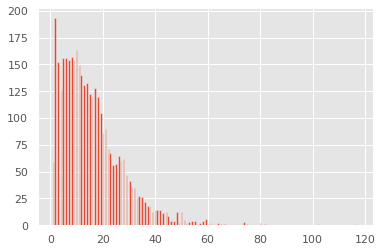

In [95]:
#Visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=200)
plt.show()

In [96]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 117


In [97]:
#Words tagged as U-STUDIO
df_train.loc[df_train['labels'] == 'U-STUDIO', 'words'].head()


Series([], Name: words, dtype: object)

In [98]:
df_train.loc[df_train['labels'] == 'B-STUDIO', 'words'].head()


29     Disney
47     Disney
55     Disney
57     Marvel
145    Warner
Name: words, dtype: object

In [99]:
df_train.loc[df_train['labels'] == 'I-STUDIO', 'words'].head()


15963        Century
20662          Movie
25726       Pictures
25812    Searchlight
37896        Picture
Name: words, dtype: object

In [100]:
df_train.loc[df_train['labels'] == 'L-STUDIO', 'words'].head()

522      Studios
826           TV
1809    Pictures
1998        Plus
2220       Prime
Name: words, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


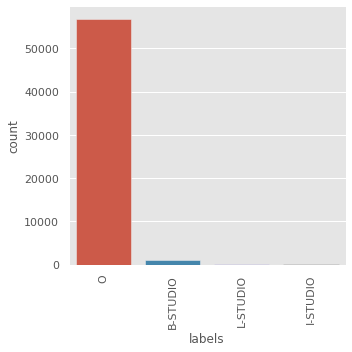

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


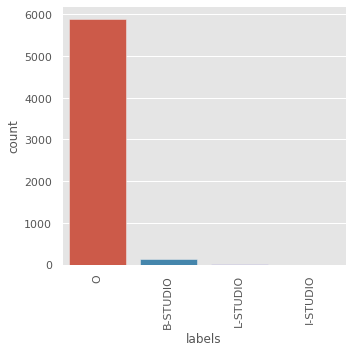

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


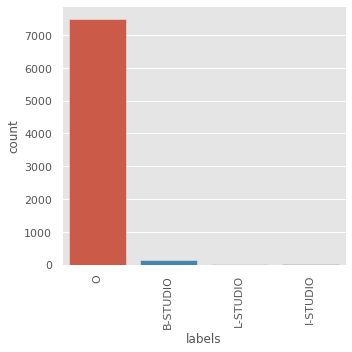

In [101]:
#Words distribution across Tags (train_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


#Words distribution across Tags (dev_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_dev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


#Words distribution across Tags (test_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


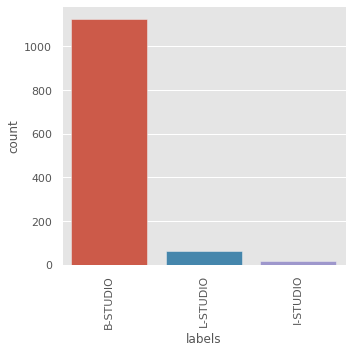

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


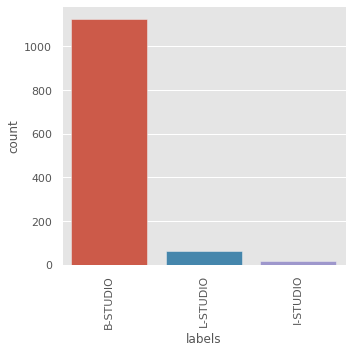

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


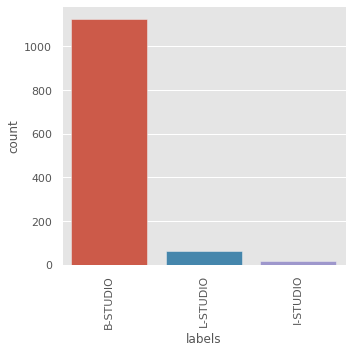

In [102]:
#Words distribution across Tags without O tag (train_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train.loc[df_train['labels'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

#Words distribution across Tags without O tag (dev_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train.loc[df_train['labels'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

#Words distribution across Tags without O tag (test_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train.loc[df_train['labels'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [103]:

def plot_labels(df, title=None):
  ds_labels = df["labels"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(5,5))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Tags")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

In [104]:
count_train = df_train["labels"].value_counts(normalize=False)
print(count_train)

count_dev = df_dev["labels"].value_counts(normalize=False)
print(count_dev)

count_test = df_test["labels"].value_counts(normalize=False)
print(count_test)



O           56836
B-STUDIO     1127
L-STUDIO       61
I-STUDIO       16
Name: labels, dtype: int64
O           5896
B-STUDIO     141
L-STUDIO       8
I-STUDIO       1
Name: labels, dtype: int64
O           7501
B-STUDIO     141
L-STUDIO       6
I-STUDIO       2
Name: labels, dtype: int64


------------------------------------------
# **4. Feature Engineering**

**4.1 Vectorization**

The following settings for vectorization were used:



*   Word representation: CountVectorizer;
*   N-grams: unigram & bigram;
*   Minimum document frequency: 5;
*   Convert to lowercase;
*   Try binary counter;

------------------------------------------

In [105]:
labelencoder = LabelEncoder()
df_train['sentence_id'] = labelencoder.fit_transform(df_train['sentence_id'])
df_dev['sentence_id'] = labelencoder.fit_transform(df_dev['sentence_id'])
df_test['sentence_id'] = labelencoder.fit_transform(df_test['sentence_id'])


In [106]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = CountVectorizer(analyzer='word', 
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["words"])
  X_dev = vectorizer.transform(df_dev["words"])
  X_test = vectorizer.transform(df_test["words"])
  y_train = df_train["labels"].tolist()
  y_dev = df_dev["labels"].tolist()
  y_test = df_test["labels"].tolist()
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

-----------------------------------------
**4.2 Test for CountVectorizer (Integer)**

-----------------------------------------

In [107]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [108]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [109]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [110]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [111]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))



In [112]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 0.09, NNZs: 1197, Bias: -0.007859, T: 52236, Avg. loss: 0.876020
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 1197, Bias: -0.006901, T: 52236, Avg. loss: 0.869541
Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 1197, Bias: -0.007070, T: 104472, Avg. loss: 0.868748
Total training time: 0.02 seconds.
Norm: 0.05, NNZs: 1197, Bias: -0.008050, T: 104472, Avg. loss: 0.875417
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 1197, Bias: -0.007169, T: 156708, Avg. loss: 0.868589
Total training time: 0.04 seconds.
Norm: 0.05, NNZs: 1197, Bias: -0.008158, T: 156708, Avg. loss: 0.874499
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 1197, Bias: -0.007239, T: 208944, Avg. loss: 0.868418
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.05, NNZs: 1197, Bias: -0.008234, T: 208944, Avg. loss: 0.874420
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 1197, Bias: -0.007

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, average=False, class_weight='balanced',
                               early_stopping=True, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=1, warm_start=False))],
         verbose=False)



---


# **Experiments and Results**
Machine learning models and transformer-based models will be evaluated.

### **Machine Learning Models**

*   Logistic Regression
*   Random Forest
*   Linear SVM

### **Evaluation Metrics**

*   Precision
*   Recall
*   F1 score
*   Accuracy
*   Confusion matrix

---

In [113]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".png")
  plt.show()
  print()

In [114]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

Training Set
Accuracy: 0.651671261199173

              precision    recall  f1-score   support

    B-STUDIO     0.9127    0.9184    0.9155      1127
    I-STUDIO     0.0007    0.8125    0.0013        16
    L-STUDIO     0.1478    0.7705    0.2480        61
           O     1.0000    0.6462    0.7851     56836

    accuracy                         0.6517     58040
   macro avg     0.5153    0.7869    0.4875     58040
weighted avg     0.9971    0.6517    0.7868     58040



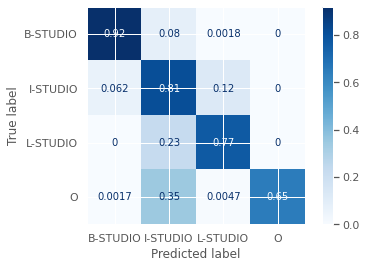


Validation Set
Accuracy: 0.6415812107178299

              precision    recall  f1-score   support

    B-STUDIO     0.9071    0.9007    0.9039       141
    I-STUDIO     0.0005    1.0000    0.0009         1
    L-STUDIO     0.1395    0.7500    0.2353         8
           O     0.9992    0.6352    0.7766      5896

    accuracy                         0.6416      6046
   macro avg     0.5116    0.8215    0.4792      6046
weighted avg     0.9958    0.6416    0.7788      6046



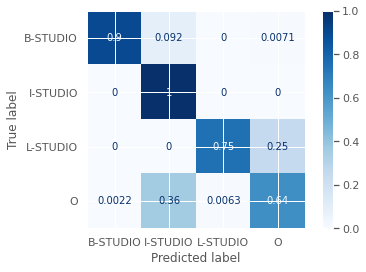


Testing Set
Accuracy: 0.6460130718954248

              precision    recall  f1-score   support

    B-STUDIO     0.8844    0.9220    0.9028       141
    I-STUDIO     0.0008    1.0000    0.0015         2
    L-STUDIO     0.0769    0.5000    0.1333         6
           O     1.0000    0.6408    0.7811      7501

    accuracy                         0.6460      7650
   macro avg     0.4905    0.7657    0.4547      7650
weighted avg     0.9969    0.6460    0.7826      7650



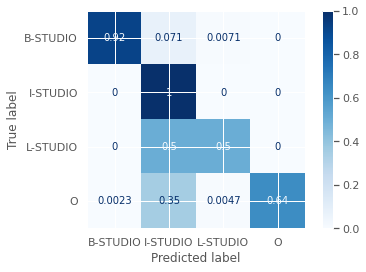

In [115]:
evaluate_model(clf_lr, model_name="lr_count_int")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    9.8s finished


Training Set
Accuracy: 0.5443487250172295

              precision    recall  f1-score   support

    B-STUDIO     0.9343    0.8962    0.9149      1127
    I-STUDIO     0.0005    0.7500    0.0009        16
    L-STUDIO     0.1396    0.7049    0.2331        61
           O     1.0000    0.5371    0.6989     56836

    accuracy                         0.5443     58040
   macro avg     0.5186    0.7221    0.4619     58040
weighted avg     0.9975    0.5443    0.7024     58040



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    9.8s finished


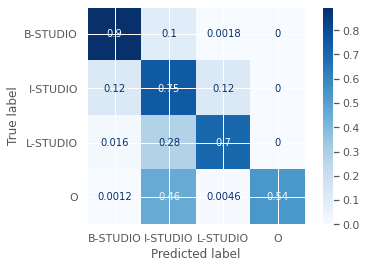

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.1s finished


Validation Set
Accuracy: 0.5496195831955012

              precision    recall  f1-score   support

    B-STUDIO     0.9618    0.8936    0.9265       141
    I-STUDIO     0.0004    1.0000    0.0007         1
    L-STUDIO     0.1429    0.7500    0.2400         8
           O     0.9994    0.5410    0.7020      5896

    accuracy                         0.5496      6046
   macro avg     0.5261    0.7962    0.4673      6046
weighted avg     0.9972    0.5496    0.7065      6046



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.1s finished


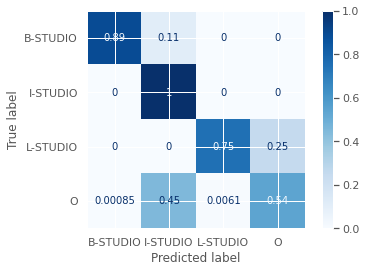

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.3s finished


Testing Set
Accuracy: 0.5594771241830065

              precision    recall  f1-score   support

    B-STUDIO     0.8973    0.9291    0.9129       141
    I-STUDIO     0.0003    0.5000    0.0006         2
    L-STUDIO     0.0526    0.3333    0.0909         6
           O     1.0000    0.5527    0.7119      7501

    accuracy                         0.5595      7650
   macro avg     0.4875    0.5788    0.4291      7650
weighted avg     0.9971    0.5595    0.7150      7650



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.4s finished


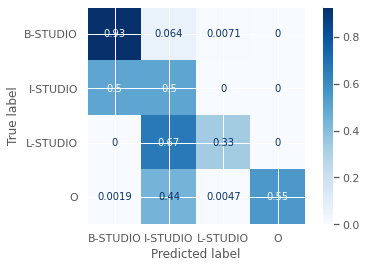

In [116]:
evaluate_model(clf_rf, model_name="rf")

Training Set
Accuracy: 0.9849241902136457

              precision    recall  f1-score   support

    B-STUDIO     0.9110    0.9175    0.9142      1127
    I-STUDIO     0.0136    0.3750    0.0262        16
    L-STUDIO     0.1088    0.5246    0.1803        61
           O     0.9986    0.9869    0.9928     56836

    accuracy                         0.9849     58040
   macro avg     0.5080    0.7010    0.5284     58040
weighted avg     0.9957    0.9849    0.9901     58040



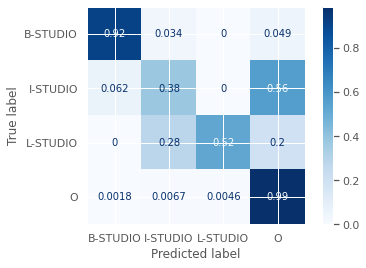


Validation Set
Accuracy: 0.9827985444922263

              precision    recall  f1-score   support

    B-STUDIO     0.9137    0.9007    0.9071       141
    I-STUDIO     0.0222    1.0000    0.0435         1
    L-STUDIO     0.1000    0.5000    0.1667         8
           O     0.9979    0.9854    0.9916      5896

    accuracy                         0.9828      6046
   macro avg     0.5085    0.8465    0.5272      6046
weighted avg     0.9946    0.9828    0.9884      6046



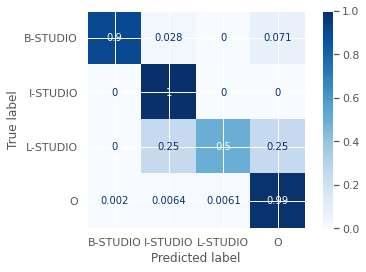


Testing Set
Accuracy: 0.9832679738562091

              precision    recall  f1-score   support

    B-STUDIO     0.8784    0.9220    0.8997       141
    I-STUDIO     0.0143    0.5000    0.0278         2
    L-STUDIO     0.0571    0.3333    0.0976         6
           O     0.9989    0.9851    0.9919      7501

    accuracy                         0.9833      7650
   macro avg     0.4872    0.6851    0.5042      7650
weighted avg     0.9957    0.9833    0.9893      7650



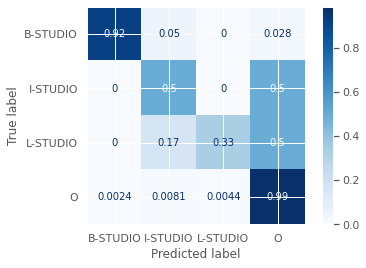

In [117]:
evaluate_model(clf_sgd, model_name="sgd")

# **Deep Learning**
Transformer-based models including BERT, DistilBERT, RoBERTa, and XLNet will be used in this section.

In [118]:
label = df_train["labels"].unique().tolist()
print(label)

cuda_available = torch.cuda.is_available()

['O', 'B-STUDIO', 'L-STUDIO', 'I-STUDIO']


### **Evaluation Metrics for Transformers**

In [119]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
  y = df['labels'].tolist()
  y_pred, raw_outputs = model.predict(df['words'])

  predicted = []
  true = []

  for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

  
  print(label + ' Set')
  print("Accuracy:", accuracy_score(true, predicted))
  print()

  print(classification_report(true, predicted, digits=4))
  df_cm = pd.DataFrame(confusion_matrix(true, predicted, normalize='true'), 
                       range(1,5), range(1,5))
  plt.figure(figsize=(6,4))
  ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [120]:
def evaluate_bert_model(model, model_name="model"):
  #evaluate_bert_model_one(model, df_dev, label="Validation", model_name=model_name)
  evaluate_bert_model_one(model, df_test, label="Testing", model_name=model_name)
  # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)

# **BERT (Bidirectional Encoder Representations)**

### **Tests for Maximum Sequence Level**
max_seq_length: 32 vs. 64. vs 128

In [121]:
model_bert_base_cased_32 = \
NERModel('bert',
                    'bert-base-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_cased_32/",
                          "best_model_dir": "outputs_bert_base_cased_32/best_model/",
                          "max_seq_length": 32,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [122]:
model_bert_base_cased_32.train_model(df_train, eval_data = df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.08587384757315861)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9974814422057264

              precision    recall  f1-score   support

    B-STUDIO     0.9456    0.9521    0.9488       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9985    0.9991    0.9988      7393

    accuracy                         0.9975      7544
   macro avg     0.4860    0.4878    0.4869      7544
weighted avg     0.9968    0.9975    0.9972      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


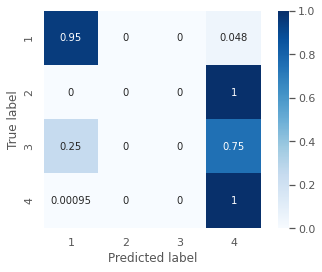

In [123]:
evaluate_bert_model(model_bert_base_cased_32, model_name="bert_base_cased_32")

In [124]:
score_base_cased_32, model_outputs_bert_cased_32, preds_bert_cased_32 = model_bert_base_cased_32.eval_model(df_test)
print(score_base_cased_32)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.01067907689706525, 'precision': 0.8943661971830986, 'recall': 0.9548872180451128, 'f1_score': 0.9236363636363636}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [125]:
model_bert_base_cased_64 = \
NERModel('bert',
                    'bert-base-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [126]:
model_bert_base_cased_64.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.06097081079308831)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9974814422057264

              precision    recall  f1-score   support

    B-STUDIO     0.9521    0.9521    0.9521       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.5000    0.2500    0.3333         4
           O     0.9985    0.9989    0.9987      7393

    accuracy                         0.9975      7544
   macro avg     0.6126    0.5502    0.5710      7544
weighted avg     0.9972    0.9975    0.9973      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


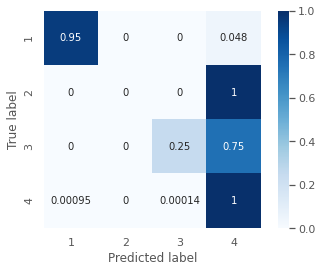

In [127]:
evaluate_bert_model(model_bert_base_cased_64, model_name="bert_base_cased_64")

In [128]:
score_base_cased_64, model_outputs_bert_cased_64, preds_bert_cased_64 = model_bert_base_cased_64.eval_model(df_test)
print(score_base_cased_64)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.010280473082290836, 'precision': 0.8874172185430463, 'recall': 0.9571428571428572, 'f1_score': 0.9209621993127148}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [129]:
model_bert_base_cased_128 = \
NERModel('bert',
                    'bert-base-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_cased_128/",
                          "best_model_dir": "outputs_bert_base_cased_128/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [130]:
model_bert_base_cased_128.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.0828269182204857)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9974814422057264

              precision    recall  f1-score   support

    B-STUDIO     0.9459    0.9589    0.9524       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9985    0.9989    0.9987      7393

    accuracy                         0.9975      7544
   macro avg     0.4861    0.4895    0.4878      7544
weighted avg     0.9968    0.9975    0.9972      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


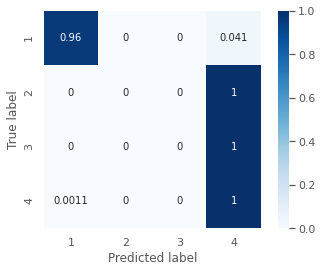

In [131]:
evaluate_bert_model(model_bert_base_cased_128, model_name="bert_base_cased_128")

In [132]:
score_base_cased_128, model_outputs_bert_cased_128, preds_bert_cased_64 = model_bert_base_cased_128.eval_model(df_test)
print(score_base_cased_128)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.009839594470469233, 'precision': 0.8717948717948718, 'recall': 0.9645390070921985, 'f1_score': 0.9158249158249158}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [133]:
del model_bert_base_cased_128



---


# **Cased Large BERT**


---



In [134]:
model_bert_large_cased = \
NERModel('bert',
                    'bert-large-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_large_cased/",
                          "best_model_dir": "outputs_bert_large_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-c

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [135]:
model_bert_large_cased.train_model(df_train, eval_data = df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.05395918816718442)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9968186638388123

              precision    recall  f1-score   support

    B-STUDIO     0.9635    0.9041    0.9329       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9974    0.9993    0.9984      7393

    accuracy                         0.9968      7544
   macro avg     0.4902    0.4759    0.4828      7544
weighted avg     0.9961    0.9968    0.9964      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


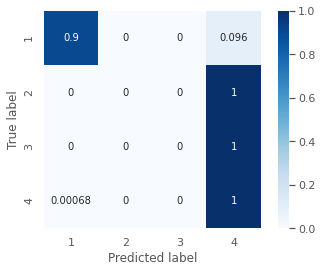

In [136]:
evaluate_bert_model(model_bert_large_cased, model_name="model_bert_large_cased")

In [137]:
score_base_cased_large, model_outputs_bert_cased_large, preds_bert_cased_large = model_bert_large_cased.eval_model(df_test)
print(score_base_cased_large)

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.009606462104075343, 'precision': 0.8933333333333333, 'recall': 0.950354609929078, 'f1_score': 0.9209621993127147}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [138]:
del model_bert_large_cased


---
# **Uncased BERT**


---






In [169]:
model_bert_base_uncased_128 = \
NERModel('bert',
                    'bert-base-uncased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 5000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [170]:
model_bert_base_uncased_128.train_model(df_train, eval_data = df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


(232,
 {'eval_loss': [0.38031673338264227],
  'f1_score': [0.0],
  'global_step': [232],
  'precision': [0.0],
  'recall': [0.0],
  'train_loss': [0.004809139762073755]})

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9799840933191941

              precision    recall  f1-score   support

    B-STUDIO     0.0000    0.0000    0.0000       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9800    1.0000    0.9899      7393

    accuracy                         0.9800      7544
   macro avg     0.2450    0.2500    0.2475      7544
weighted avg     0.9604    0.9800    0.9701      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


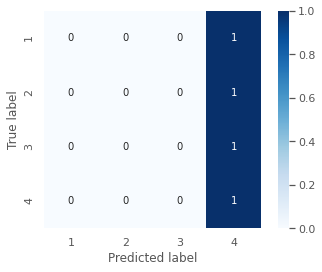

In [171]:
evaluate_bert_model(model_bert_base_uncased_128, model_name="bert_base_uncased_128")

In [172]:
score_base_uncased_128, model_outputs_bert_uncased_128, preds_bert_uncased_128 = model_bert_base_uncased_128.eval_model(df_test)
print(score_base_uncased_128)

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.027926698536217466, 'precision': 0.8923076923076924, 'recall': 0.8226950354609929, 'f1_score': 0.8560885608856089}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))




---


# **DistilBERT**
### **Uncased DistilBERT**
---



In [173]:
model_distilbert_base_uncased = \
NERModel('distilbert', 
                    'distilbert-base-uncased', 
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_distilbert_base_uncased/",
                          "best_model_dir": "outputs_distilbert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [174]:
model_distilbert_base_uncased.train_model(df_train, eval_data = df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.09975049172925506)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9799840933191941

              precision    recall  f1-score   support

    B-STUDIO     0.0000    0.0000    0.0000       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9800    1.0000    0.9899      7393

    accuracy                         0.9800      7544
   macro avg     0.2450    0.2500    0.2475      7544
weighted avg     0.9604    0.9800    0.9701      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


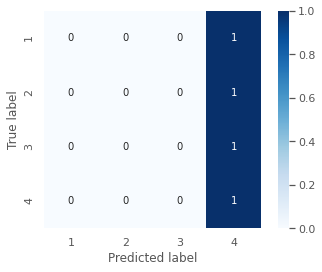

In [175]:
evaluate_bert_model(model_distilbert_base_uncased, model_name="model_distilbert_base_uncased")

In [176]:
score_model_distilbert_base_uncased, model_outputs_distilbert_base_uncased, preds_distilbert_base_uncased = model_distilbert_base_uncased.eval_model(df_test)
print(score_base_uncased_128)

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.027926698536217466, 'precision': 0.8923076923076924, 'recall': 0.8226950354609929, 'f1_score': 0.8560885608856089}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [177]:
del model_distilbert_base_uncased




---


# **Cased DistilBERT**


---



In [148]:
model_distilbert_base_cased = \
NERModel('distilbert', 
                    'distilbert-base-cased', 
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_distilbert_base_cased/",
                          "best_model_dir": "outputs_distilbert_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [149]:
model_distilbert_base_cased.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.09104075438567791)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9961558854718982

              precision    recall  f1-score   support

    B-STUDIO     0.9549    0.8699    0.9104       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9969    0.9993    0.9981      7393

    accuracy                         0.9962      7544
   macro avg     0.4879    0.4673    0.4771      7544
weighted avg     0.9954    0.9962    0.9957      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


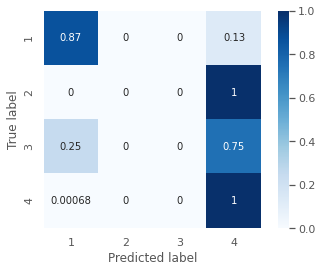

In [150]:
evaluate_bert_model(model_distilbert_base_cased, model_name="model_distilbert_base_cased")

In [151]:
score_model_distilbert_base_cased, model_outputs_distilbert_base_cased, preds_distilbert_base_cased = model_distilbert_base_cased.eval_model(df_test)
print(score_base_cased_128)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.009839594470469233, 'precision': 0.8717948717948718, 'recall': 0.9645390070921985, 'f1_score': 0.9158249158249158}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))




---


# **RoBERTa**



---



In [152]:
model_roberta_base_128 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [153]:
model_roberta_base_128.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.06823356018917523)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9970837751855779

              precision    recall  f1-score   support

    B-STUDIO     0.9850    0.8973    0.9391       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9973    0.9997    0.9985      7393

    accuracy                         0.9971      7544
   macro avg     0.4956    0.4742    0.4844      7544
weighted avg     0.9964    0.9971    0.9967      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


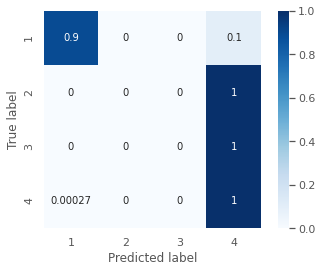

In [154]:
evaluate_bert_model(model_roberta_base_128, model_name="model_roberta_base_128")

In [155]:
score_model_roberta_base_128, model_outputs_roberta_base_128, preds_roberta_base_128 = model_roberta_base_128.eval_model(df_test)
print(score_model_roberta_base_128)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.012769293343160949, 'precision': 0.9136690647482014, 'recall': 0.900709219858156, 'f1_score': 0.9071428571428571}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [156]:
model_roberta_base_64 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [157]:
model_roberta_base_64.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.0724021812324093)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9978791092258749

              precision    recall  f1-score   support

    B-STUDIO     0.9787    0.9452    0.9617       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9982    0.9996    0.9989      7393

    accuracy                         0.9979      7544
   macro avg     0.4942    0.4862    0.4901      7544
weighted avg     0.9972    0.9979    0.9975      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


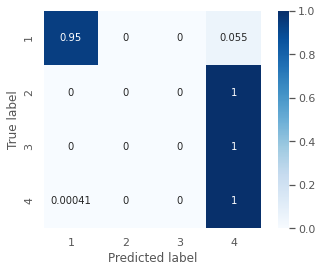

In [158]:
evaluate_bert_model(model_roberta_base_64, model_name="model_roberta_base_64")

In [159]:
score_model_roberta_base_64, model_outputs_roberta_base_64, preds_roberta_base_64 = model_roberta_base_64.eval_model(df_test)
print(score_model_roberta_base_64)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.013249133588742244, 'precision': 0.8827586206896552, 'recall': 0.9142857142857143, 'f1_score': 0.8982456140350877}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [160]:
model_roberta_base_32 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 32,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [161]:
model_roberta_base_32.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.0907177401702562)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9972163308589608

              precision    recall  f1-score   support

    B-STUDIO     0.9851    0.9041    0.9429       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9974    0.9997    0.9986      7393

    accuracy                         0.9972      7544
   macro avg     0.4956    0.4760    0.4854      7544
weighted avg     0.9965    0.9972    0.9968      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


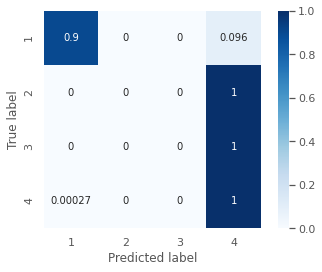

In [162]:
evaluate_bert_model(model_roberta_base_32, model_name="model_roberta_base_32")

In [163]:
score_model_roberta_base_32, model_outputs_roberta_base_32, preds_roberta_base_32 = model_roberta_base_32.eval_model(df_test)
print(score_model_roberta_base_32)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.021623799226629565, 'precision': 0.8345323741007195, 'recall': 0.9133858267716536, 'f1_score': 0.8721804511278195}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [164]:
# x_train= df_train[["sentence_id","words"]]
# x_dev= df_dev[["sentence_id","words"]]

# y_train =df_train["labels"]
# y_dev =df_dev["labels"]

# x_test= df_test[["sentence_id","words"]]
# y_test =df_test["labels"]



In [165]:

# #building up train data, dev data and test data
# train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
# dev_data = pd.DataFrame({"sentence_id":x_dev["sentence_id"],"words":x_dev["words"],"labels":y_dev})
# test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})



In [166]:
test_text = ["1. TriStar Pictures And Entertainment One’s Romantic Comedy, Happiest Season, Starring Kristen Stewart, To Stream Exclusively On Hulu In The U.S. This Holiday Season." ,
            "2. Sony Pictures Television’s Gemstone Studios Announces Finalists In Rising Storytellers Search." ,
            "3. 20th Century Fox is one of the Big Six studios." ,
            "4. NBCUniversal is primarily involved in the media and entertainment industry." ,
            "5. A legendary producer and global distributor of filmed entertainment since 1912, Paramount Pictures' library consists of more than 1,000 film titles with rights to an additional 2,500, featuring films by Hollywood's most respected filmmakers." ,
            "6. Create your profile using your resume, LinkedIn, Facebook, or Google+ profile." ,
            "7. To view all open jobs at ViacomCBS, click here." ,
            "8. Universal Pictures is owned by Comcast through its subsidiary NBCUniversal." ,
            "9. Lionsgate's Motion Picture Group encompasses eight film labels and more than 40 feature film releases a year." ,
            "10. Metro-Goldwyn-Mayer Studios Inc is an American media company, involved primarily in the production and distribution of feature films and television programs." ,
            "11. New Line Productions, Inc., d/b/a New Line Cinema, is an American film production studio and a label of the Warner Bros. Pictures Group division." ,
            "12.  Focus Features along with Sight Unseen, Makeready and Hillman Grad Productions have announced plans to begin production next year on A.V. Rockwell’s A Thousand and One. " ,
            "13. Capital Motion Picture Group has picked up North American and U.K. rights to Cold War thriller “The Man on the Other Side,” directed by Marcus Lim." ,
            "14. Watch Netflix movies & TV shows online or stream right to your smart TV, game console, PC, Mac, mobile, tablet and more." ,
            "15. Warner Bros. Entertainment was founded in 1923 and has created some of the best movies which have innovated the industry, such as The Jazz Singer introducing synchronized sound."
]



In [167]:
predictions, raw_outputs = model_roberta_base_32.predict(test_text)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

In [168]:
predictions

[[{'1.': 'O'},
  {'TriStar': 'O'},
  {'Pictures': 'O'},
  {'And': 'O'},
  {'Entertainment': 'O'},
  {'One’s': 'O'},
  {'Romantic': 'O'},
  {'Comedy,': 'O'},
  {'Happiest': 'O'},
  {'Season,': 'O'},
  {'Starring': 'O'},
  {'Kristen': 'O'},
  {'Stewart,': 'O'}],
 [{'2.': 'O'},
  {'Sony': 'B-STUDIO'},
  {'Pictures': 'O'},
  {'Television’s': 'O'},
  {'Gemstone': 'O'},
  {'Studios': 'O'},
  {'Announces': 'O'},
  {'Finalists': 'O'},
  {'In': 'O'},
  {'Rising': 'O'},
  {'Storytellers': 'O'},
  {'Search.': 'O'}],
 [{'3.': 'O'},
  {'20th': 'O'},
  {'Century': 'O'},
  {'Fox': 'B-STUDIO'},
  {'is': 'O'},
  {'one': 'O'},
  {'of': 'O'},
  {'the': 'O'},
  {'Big': 'O'},
  {'Six': 'O'},
  {'studios.': 'O'}],
 [{'4.': 'O'},
  {'NBCUniversal': 'B-STUDIO'},
  {'is': 'O'},
  {'primarily': 'O'},
  {'involved': 'O'},
  {'in': 'O'},
  {'the': 'O'},
  {'media': 'O'},
  {'and': 'O'},
  {'entertainment': 'O'},
  {'industry.': 'O'}],
 [{'5.': 'O'},
  {'A': 'O'},
  {'legendary': 'O'},
  {'producer': 'O'},
  {'and